In [ ]:
!pip install transformers -q
!pip install datasets -q

In [ ]:
from transformers import BertTokenizerFast
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import ViltForQuestionAnswering, ViltFeatureExtractor
from datasets import load_dataset_builder, get_dataset_split_names 
import torch

### Preprocessing

In [ ]:
data_files={
        "train": "/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv",
        "test": "/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv"
    }

In [ ]:
dataset = load_dataset('csv', data_files = data_files)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-126e9ff79bd249ed/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id'],
        num_rows: 2494
    })
})

In [ ]:
with open('/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/answer_space.txt') as f:
    answer_space = f.read().splitlines()

print(answer_space)

['1', '10', '11', '12', '13', '14', '15', '16', '18', '19', '2', '2163', '22', '3', '4', '5', '6', '7', '8', '9', 'air_conditioner', 'air_vent', 'alarm', 'alarm_clock', 'album', 'aluminium_foil', 'apple', 'ashtray', 'baby_chair', 'baby_gate', 'back_scrubber', 'backpack', 'bag', 'ball', 'balloon', 'banana', 'banister', 'bar_of_soap', 'basket', 'basketball', 'basketball_hoop', 'bathtub', 'bean_bag', 'bed', 'bed_sheets', 'belt', 'bench', 'bicycle', 'bicycle_helmet', 'bin', 'binder', 'black', 'blackboard', 'blanket', 'blender', 'blinds', 'blue', 'board', 'book', 'book_holder', 'bookrack', 'books', 'bookshelf', 'bottle', 'bottle_of_hand_wash_liquid', 'bottle_of_liquid', 'bottle_of_listerine', 'bottle_of_perfume', 'bottle_of_soap', 'bowl', 'box', 'box_of_paper', 'bread', 'brick', 'briefcase', 'broom', 'brown', 'bucket', 'bulb', 'bunk_bed', 'business_cards', 'cabinet', 'cable_box', 'cables', 'calculator', 'calendar', 'can', 'can_of_beer', 'candelabra', 'candle', 'candlestick', 'cane', 'canist

In [ ]:
# 'picture, wall_decoration' is not in list
dataset = dataset.map(
    lambda examples: {
        'label': [answer_space.index(ans.split(',')[0]) for ans in examples['answer']]
    },
    batched=True
)
dataset

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

In [ ]:
dataset['train'][90]

{'question': 'what is on the washing machine',
 'answer': 'clothing_detergent',
 'image_id': 'image493',
 'label': 118}

In [ ]:
model = ViltForQuestionAnswering.from_pretrained('microsoft/git-base-textvqa')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

You are using a model of type git to instantiate a model of type vilt. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at microsoft/git-base-textvqa were not used when initializing ViltForQuestionAnswering: ['git.encoder.layer.3.intermediate.dense.bias', 'git.image_encoder.vision_model.encoder.layers.6.mlp.fc2.bias', 'git.image_encoder.vision_model.encoder.layers.10.layer_norm2.weight', 'git.encoder.layer.5.attention.self.key.bias', 'git.image_encoder.vision_model.encoder.layers.5.self_attn.v_proj.bias', 'git.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.bias', 'git.image_encoder.vision_model.encoder.layers.7.self_attn.q_proj.bias', 'git.visual_projection.visual_projection.1.bias', 'git.encoder.layer.3.attention.self.value.bias', 'git.encoder.layer.5.attention.output.LayerNorm.weight', 'git.image_encoder.vision_model.encoder.layers.11.mlp.fc1.bias', 'git.image_encoder.vision_model.encoder.layers.3.layer_norm1.bias', 'git.encoder.layer.2.attention.output.LayerNorm.bias', 'git.image_encoder.vision_model.encoder.layers.5.layer_norm1.bias', 'git.image_e

In [ ]:
# Load the feature extractor
feature_extractor = ViltFeatureExtractor.from_pretrained('microsoft/git-base-textvqa')

/opt/conda/lib/python3.7/site-packages/transformers/models/vilt/feature_extraction_vilt.py:31: FutureWarning: The class ViltFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViltImageProcessor instead.
  FutureWarning,


In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import os

def showExample(train=True, id):
  """
  This function show example from data like displaying image with its question and answer

  -Parameter:
  train : bool
  id : int

  -Returns:
  image with its question and answer
  """
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    
    image = Image.open(os.path.join("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images", data[id]["image_id"] + ".png"))
    display(image)

    print(f"Question:\t{data[id]['question']}")
    print(f"Answer:\t\t{data[id]['answer']}  (Label:{data[id]['label']})")

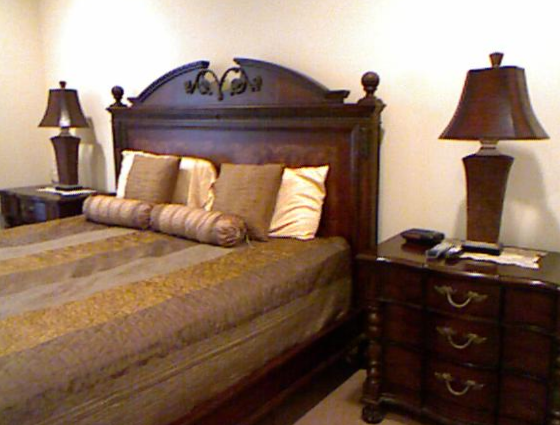

Question:	what is the colour of the lamps
Answer:		brown  (Label:76)


In [ ]:
showExample(id=20)

In [ ]:
# Add full path of the images
dataset = dataset.map(
    lambda example: {"image_path" : [os.path.join('/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images', id+ '.png') for id in example['image_id']]},
    batched=True
)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label', 'image_path'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label', 'image_path'],
        num_rows: 2494
    })
})

In [ ]:
img = Image.open(dataset['train']['image_path'][10]).convert('RGB')

# Apply the feature extractor to the image
features = feature_extractor(img, return_tensors='pt')

In [ ]:
features

{'pixel_values': tensor([[[[ 1.8281,  1.8865,  1.8719,  ..., -1.1207, -1.0769, -1.0477],
          [ 1.8865,  1.9011,  1.8865,  ..., -1.0915, -1.0477, -1.0185],
          [ 1.8865,  1.8719,  1.8573,  ..., -1.0915, -1.0331, -1.0039],
          ...,
          [-0.4054, -0.4054, -0.3908,  ..., -1.5003, -1.5003, -1.4711],
          [-0.4054, -0.3908, -0.3762,  ..., -1.5587, -1.5733, -1.5441],
          [-0.4054, -0.3908, -0.3762,  ..., -1.6025, -1.5879, -1.5587]],

         [[ 1.9548,  2.0599,  2.0749,  ..., -1.1518, -1.1518, -1.1218],
          [ 1.9848,  2.0749,  2.0749,  ..., -1.1218, -1.1218, -1.0918],
          [ 2.0299,  2.0599,  2.0599,  ..., -1.1218, -1.1068, -1.0767],
          ...,
          [-0.8216, -0.8216, -0.8066,  ..., -1.4369, -1.4519, -1.4219],
          [-0.8216, -0.8066, -0.7916,  ..., -1.5420, -1.5420, -1.5270],
          [-0.8216, -0.8066, -0.7916,  ..., -1.6470, -1.6470, -1.6020]],

         [[ 2.0179,  2.1317,  2.1459,  ..., -0.9399, -0.8688, -0.8403],
          [ 2

In [ ]:
tokens = tokenizer('What is the color of this book?', padding=True, truncation=True, return_tensors='pt')
tokens

{'input_ids': tensor([[ 101, 2054, 2003, 1996, 3609, 1997, 2023, 2338, 1029,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
def preprocess(example):
  """
  This function apply all preprocessing needed on the whole data
  like extracting features from image and tokenzing text

  -Parameters:
  example : dict

  -Returns:
  dictionary with added values from preprocessing
  """
    image = Image.open(example['image_path']).convert('RGB')
    image = feature_extractor(images=image, return_tensors='pt')

    question = tokenizer(example['question'], truncation=True, return_tensors='pt', padding=True)
    answer = tokenizer(example['answer'], padding=True, truncation=True, return_tensors='pt')
  
    example['pixel_values'] = image.pixel_values
    example['input_ids'] = question['input_ids'].flatten()
    example['attention_mask'] = question['attention_mask'].flatten()
    example['token_type_ids'] = question['token_type_ids'].flatten()
    example['labels'] = answer['input_ids'].flatten()
  
    return example

In [ ]:
dataset = dataset.map(preprocess)

  0%|          | 0/9974 [00:00<?, ?ex/s]

  0%|          | 0/2494 [00:00<?, ?ex/s]

### Training

#### Using Pytorch

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import DataCollatorWithPadding

max_seq_length = 128
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length=max_seq_length)

In [ ]:
# Train the model
train_loader = DataLoader(dataset['train'], batch_size=32, shuffle=True,collate_fn=data_collator)
val_loader = DataLoader(dataset['test'], batch_size=32, shuffle=False, collate_fn=data_collator)

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        inputs = tokenizer(batch['question'], padding='max_length', return_tensors='pt', max_length=max_seq_length)
        
#       input_ids = batch['input_ids'].to(device)
#       attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, batch['labels'])
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}")
        print("train_loss: {:.4f}".format(loss.item()))
    train_loss /= len(train_loader) 

  0%|          | 0/312 [00:14<?, ?it/s]


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`question` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
# Evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}")
            print("validation_loss: {:.4f}".format(loss.item()))
    val_loss /= len(val_loader)

In [ ]:
# Save the retrained model
torch.save(model.state_dict(), 'retrained_model.pt')

#### Another way to training using trainer API

In [ ]:
def compute_metrics(prediction):
    return {'accuracy' : (prediction['predictions'].argmax(axis=-1) == prediction['labels']).mean()}

In [ ]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

In [ ]:
# pading inputs
data_collator = DataCollatorWithPadding(tokenizer, padding=True, return_tensors="pt")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator= data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)